In [12]:
import torch, os, copy, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

from src.mechanism_base import *
from src.model_base import EmbedMLP
from src.utils import cross_entropy_high_precision, acc_rate

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loading on device: {device}")


Loading on device: cpu


In [13]:
# Define the base path where the model and data files are stored
# base_path = '../saved_models/p_47_dmodel_47_dmlp_128_act_ReLU_decay_0_fractrain_1_02082253' # Embed Full-rank# base_path = '../saved_models/p_47_dmodel_47_dmlp_128_act_ReLU_decay_1_fractrain_1_02082233' # Embed Full-rank
#base_path = '../saved_models/p_47_dmodel_47_dmlp_128_act_ReLU_decay_0_fractrain_1_DFT_02112354' # Indentity, Random Init#base_path = '../saved_models/p_47_dmodel_47_dmlp_128_act_ReLU_decay_0_fractrain_1_DFT_02112348' # Fourier Basis, Sparse Init#base_path = '../saved_models/p_47_dmodel_47_dmlp_128_act_ReLU_decay_0_fractrain_1_DFT_02112343' # Fourier Basis, Random Initbase_path = '../saved_models/p_47_dmodel_47_dmlp_128_act_ReLU_decay_0_fractrain_1_DFT_02111842' # Random Basis
#base_path = 'saved_models/p_47_dmodel_47_dmlp_128_act_ReLU_decay_0_fractrain_1_DFT_02120001' # Fourier Basis, Random Init, in only, ONLY W_OUT LEARN
#base_path = 'saved_models/p_47_dmodel_47_dmlp_128_act_ReLU_decay_0_fractrain_1_DFT_02112057' # Fourier Basis, out only

# Set model configuration parameters
d_vocab, d_model, d_mlp, act_type = 47, 47, 128, 'ReLU'  # Vocabulary size, model dimension, MLP size, and activation type
p = d_vocab  # Assign vocabulary size to variable `p`

# Define the file names for the model and data files
model_file = '9000.pth'        # File containing the trained model
train_data_file = 'train_data.pth'  # File containing the training data
test_data_file = 'test_data.pth'   # File containing the test data

# Load the model and data on the specified device
# Note: The `weights_only=True` argument assumes a custom loader function or a modified PyTorch function. 
# It is not standard in PyTorch's `torch.load`. This should be clarified or corrected.
model_data = torch.load(
    os.path.join(base_path, model_file),   # Path to the model file
    weights_only=True,                    # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                   # Specify the device to load the model onto
)
print(f"Trained Model Dict: {model_data.keys()}\n")  # Print the keys of the loaded model dictionary

# Load the training and testing data
train_data = torch.load(
    os.path.join(base_path, train_data_file),  # Path to the training data file
    weights_only=True,                         # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                        # Specify the device to load the data onto
)
test_data = torch.load(
    os.path.join(base_path, test_data_file),   # Path to the testing data file
    weights_only=True,                         # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                        # Specify the device to load the data onto
)

# Extract the model parameters from the loaded model dictionary
model_load = model_data["model"]  # Access the model section of the dictionary
for key in model_load.keys():
    # Print each model parameter's key and its shape in a formatted manner
    print(f"{key:<30} {str(model_load[key].shape):<25}")

Trained Model Dict: dict_keys(['model', 'train_loss', 'test_loss', 'grad_norm', 'param_norm', 'test_accuracy', 'train_accuracy', 'epoch'])

embed.W_E                      torch.Size([47, 47])     
mlp.W_in                       torch.Size([128, 47])    
mlp.W_out                      torch.Size([47, 128])    
mlp.basis                      torch.Size([47, 47])     


In [14]:
all_data = torch.tensor([(i, j) for i in range(p) for j in range(p)]).to(device)
all_labels = torch.tensor([(i + j) % p for i, j in all_data]).to(device)
train_labels = torch.tensor([(i + j) % p for i, j in train_data]).to(device)

fourier_basis, fourier_basis_names = get_fourier_basis(p, device)
fourier_basis_unstd, _ = get_fourier_basis_unstd(p, device)

In [15]:
model_load['mlp.basis']

tensor([[-0.0744,  0.2591, -0.2233,  ..., -0.2738,  0.0168, -0.0287],
        [-0.2431,  0.0030,  0.1035,  ..., -0.2971, -0.0632,  0.3813],
        [-0.2847, -0.0886, -0.1786,  ...,  0.1774, -0.0016,  0.2674],
        ...,
        [ 0.1107, -0.0251, -0.1520,  ..., -0.1336,  0.1524, -0.0128],
        [ 0.0942,  0.0814, -0.2562,  ...,  0.0249, -0.1328,  0.0435],
        [-0.0842,  0.1941, -0.0739,  ...,  0.0013,  0.0462,  0.0354]])

## Part 1: An Overview of Learned Model

### Part 1.1: Examine the Patterned Submodule

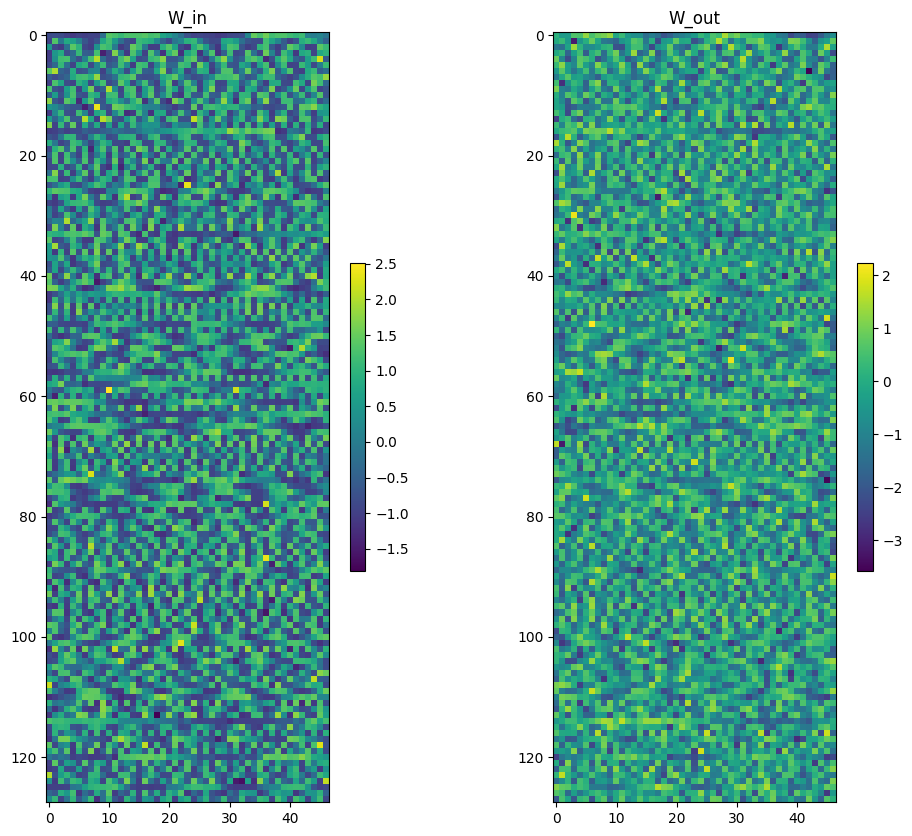

In [21]:
# Plot all four figures in one row
plt.figure(figsize=(12, 10))

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 1)
#plt.imshow(model_load['mlp.W_in'], cmap='viridis')
plt.imshow(model_load['mlp.W_in'] @ model_load['mlp.basis'], cmap='viridis')
plt.title(f'W_in')
plt.colorbar(shrink=0.4)

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 2)
#plt.imshow(model_load['mlp.W_out'].T, cmap='viridis')
plt.imshow(model_load['mlp.W_out'].T @ model_load['mlp.basis'], cmap='viridis')
plt.title(f'W_out')
plt.colorbar(shrink=0.4)

plt.show()

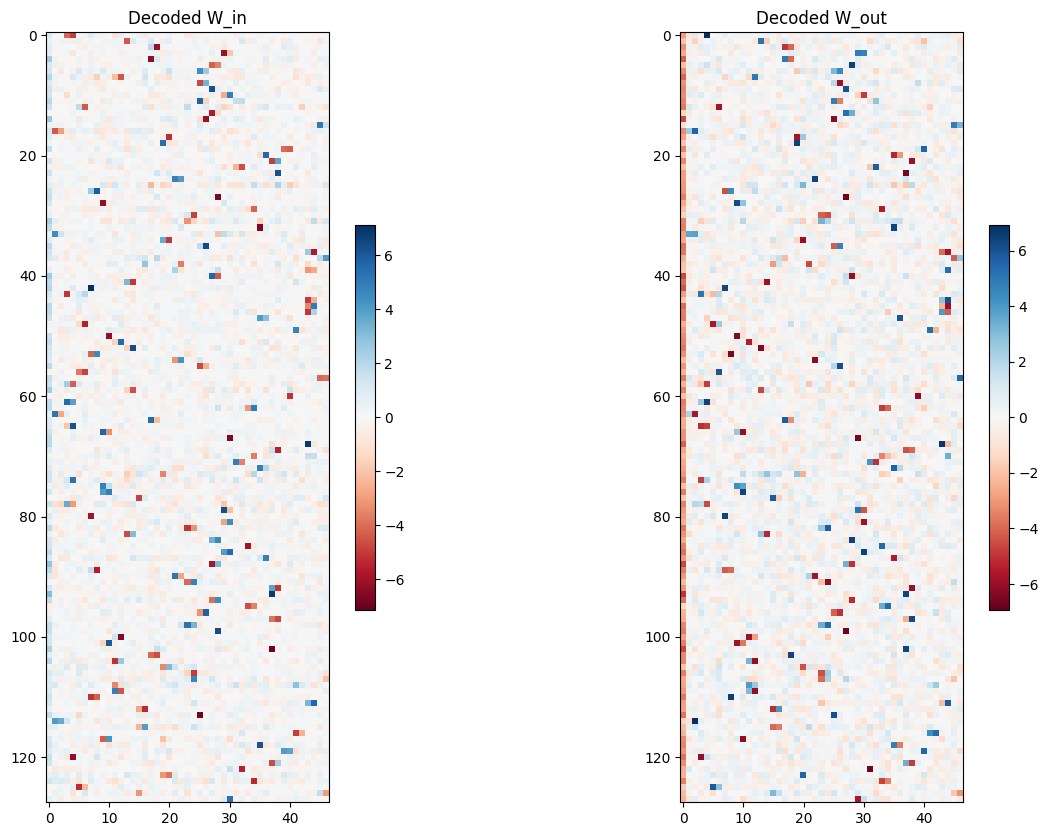

In [22]:
# Plot all four figures in one row
plt.figure(figsize=(15, 10))

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 1)
#data = model_load['mlp.W_in'] 
data = model_load['mlp.W_in'] @ model_load['mlp.basis'] @ fourier_basis.T
#data = model_load['mlp.W_in'] @ fourier_basis.T
abs_max = np.abs(data).max()
plt.imshow(data, cmap='RdBu', vmin=-abs_max, vmax=abs_max)
plt.title(f'Decoded W_in')
plt.colorbar(shrink=0.5)

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 2)
#data = model_load['mlp.W_out'].T 
data = model_load['mlp.W_out'].T @ model_load['mlp.basis'] @ fourier_basis.T
#data = model_load['mlp.W_out'].T @ fourier_basis.T
abs_max = np.abs(data).max()
plt.imshow(data, cmap='RdBu', vmin=-abs_max, vmax=abs_max)
plt.title(f'Decoded W_out')
plt.colorbar(shrink=0.5)

plt.show()

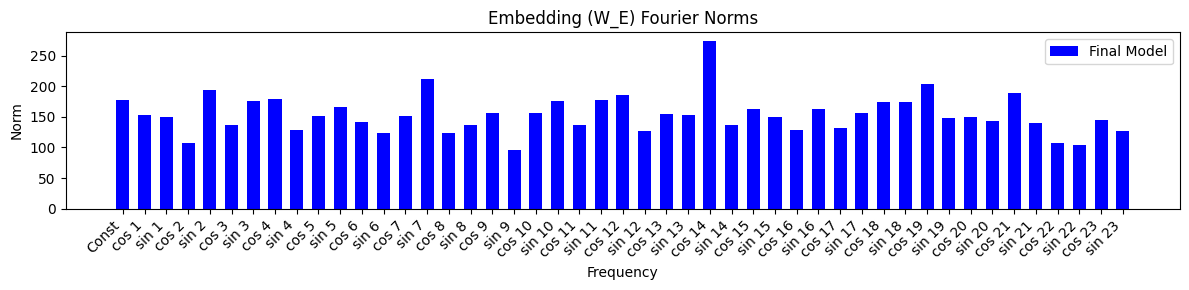

In [18]:
# Compute the norms of the Fourier components
#norms = (model_load['mlp.W_in'] @fourier_basis.T).pow(2).sum(0).detach().cpu().numpy()
norms = (model_load['mlp.W_out'].T @ fourier_basis.T).pow(2).sum(0).detach().cpu().numpy()
#norms = (model_load['mlp.W_out'].T @ model_load['mlp.basis'] @ fourier_basis.T).pow(2).sum(0).detach().cpu().numpy()
#norms = (model_load['mlp.W_out'].T ).pow(2).sum(0).detach().cpu().numpy()

# Plot the bar plot for "embed.W_E"
fig, ax = plt.subplots(figsize=(12, 3))

# x-axis labels
labels = fourier_basis_names
x = np.arange(len(labels))  # Frequency indices
width = 0.6  # Width of the bars

# Plot bars for the final model
ax.bar(x, norms, width, label="Final Model", color="blue")

# Customize plot
ax.set_title("Embedding (W_E) Fourier Norms")
ax.set_ylabel("Norm")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

# Add x-axis label and adjust layout
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

In [19]:
def decode_weights(model_load, fourier_basis_unstd):
    """
    Decodes the weights using the given model and Fourier basis, and computes the maximum frequency list.

    Parameters:
        model_load (dict): A dictionary containing the model's weights.
        fourier_basis_unstd (torch.Tensor): The Fourier basis matrix.

    Returns:
        tuple: A tuple containing:
            - W_in_decode (torch.Tensor): Decoded weights for W_in.
            - W_out_decode (torch.Tensor): Decoded weights for W_out.
            - max_freq_ls (list): List of maximum frequencies derived from W_in_decode.
    """
    # Decode the weights
    W_in_decode = model_load['mlp.W_in'] @ model_load['embed.W_E'] @ fourier_basis_unstd.T
    # W_in_decode = model_load['mlp.W_in'] @ fourier_basis_unstd.T
    W_out_decode = model_load['mlp.W_out'].T @ fourier_basis_unstd.T

    # Find the maximum frequency list
    max_ls = torch.argmax(abs(W_in_decode), dim=1)
    max_freq_ls = [(id.item() + 1) // 2 for id in max_ls]

    return W_in_decode, W_out_decode, max_freq_ls

In [20]:
W_in_decode, W_out_decode, max_freq_ls = decode_weights(model_load, fourier_basis)
for neuron in range(d_mlp):
    coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
    coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
    print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]} , Scale {coeff_in_scale:.2f},{coeff_out_scale:.2f}, 2*Phi(in) {normalize_to_pi(2*coeff_in_phi):.2f}, Phi(out) {coeff_out_phi:.2f}")

Neuron 0: Freq 3 , Scale 2.54,1.62, 2*Phi(in) -1.03, Phi(out) 0.76
Neuron 1: Freq 7 , Scale 1.61,0.83, 2*Phi(in) -0.23, Phi(out) -2.68
Neuron 2: Freq 2 , Scale 2.47,1.62, 2*Phi(in) 2.94, Phi(out) -1.36
Neuron 3: Freq 4 , Scale 2.64,1.04, 2*Phi(in) 1.89, Phi(out) -1.07
Neuron 4: Freq 1 , Scale 2.63,1.59, 2*Phi(in) -0.85, Phi(out) 0.83
Neuron 5: Freq 20 , Scale 2.18,1.16, 2*Phi(in) 2.90, Phi(out) -1.57
Neuron 6: Freq 10 , Scale 2.02,0.28, 2*Phi(in) 2.75, Phi(out) 2.22
Neuron 7: Freq 12 , Scale 2.21,1.48, 2*Phi(in) 2.62, Phi(out) 1.64
Neuron 8: Freq 5 , Scale 2.04,0.85, 2*Phi(in) -2.26, Phi(out) -0.37
Neuron 9: Freq 9 , Scale 2.43,0.38, 2*Phi(in) -0.24, Phi(out) -3.05
Neuron 10: Freq 9 , Scale 3.50,1.18, 2*Phi(in) 0.99, Phi(out) 0.59
Neuron 11: Freq 8 , Scale 2.12,0.55, 2*Phi(in) -2.09, Phi(out) -0.96
Neuron 12: Freq 6 , Scale 2.69,1.08, 2*Phi(in) 0.25, Phi(out) 2.44
Neuron 13: Freq 6 , Scale 2.27,1.32, 2*Phi(in) 0.04, Phi(out) 1.45
Neuron 14: Freq 13 , Scale 2.99,1.03, 2*Phi(in) -0.08, P